In [52]:
import numpy as np
import geopandas as gp
import pandas as pd
import pysal as ps
import pylab as pl
from shapely.geometry import Point
import seaborn as sns
import shapefile
import mplleaflet
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
df = pd.read_csv('JoinACSFCCPluto.csv')

In [9]:
myshapefile = 'JOINACSPLUTOFCC/JOINACSPLUTOFCC.shp'
gdf = gp.read_file(myshapefile)

In [9]:
# shapes['FIPS'] = shapes.GEOID.astype(int64)

In [10]:
# merged = shapes.merge(df, on='FIPS')

# set pysal weights

In [7]:
psGeom = ps.open(myshapefile, 'r')

In [8]:
# find weight

w = ps.buildContiguity(psGeom,criterion='queen')
w.transform = 'R'

Island id:  [1026]


In [17]:
# glocal Moran
Y = gdf['bscore_raw'].values
sl = ps.lag_spatial(w, Y)
gdf['w_percent'] = sl
mi = ps.Moran(Y, w)
print ('\nGlobal I: {}\nExpected I: {}\nSignificance: {}'.format(mi.I, mi.EI, mi.p_sim))


Global I: 0.904202285027
Expected I: -0.000463606861382
Significance: 0.001


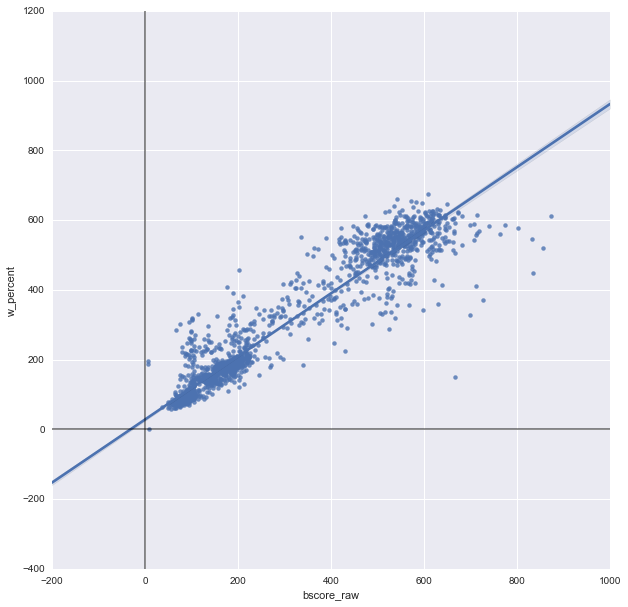

In [19]:
f, ax = pl.subplots(1, figsize=(10,10))
sns.regplot(x='bscore_raw', y='w_percent', data=gdf)
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
plt.show()

In [20]:
# local Moran

lisa = ps.Moran_Local(Y, w)

In [55]:
# filter for significance
S = lisa.p_sim < 0.05

In [56]:
# put into quadrants
Q = lisa.q

In [57]:
# reload into a dataframe
records = map(lambda x: (gdf.iloc[x]['FIPS'], Q[x], gdf.geometry.iloc[x]),
              [i for i,s in enumerate(S) if s])
gdata = gp.GeoDataFrame(records, columns=('FIPS', 'quadrant', 'geometry'))
gdata.head()

,FIPS,quadrant,geometry
0,3.600500e+10,3,"POLYGON ((-73.929219 40.80956399999999, -73.92..."
1,3.600500e+10,3,"POLYGON ((-73.917964 40.806116, -73.917479 40...."
2,3.600500e+10,3,"POLYGON ((-73.924683 40.812384, -73.9228749999..."
3,3.600500e+10,3,"POLYGON ((-73.876402 40.82897699999999, -73.87..."
4,3.600501e+10,3,"POLYGON ((-73.921784 40.819527, -73.9214779999..."


QUADRANTS

Q1 = access high (uniformly high access) (q1,pos) high-high

Q2 = access island inequity (low access surrounded by high access) (q2, neg)

Q3 = access low (uniformly low access) (q3,pos) low-low

Q4 = access island available (high access surrounded by low access) (q4, neg)

In [58]:
final_merge = gdf.merge(gdata,how='inner',on='FIPS')
final_merge = final_merge.drop(['geometry_y'],1)

In [51]:
# final_merge.to_csv('merged_w_moran.csv',index=False)

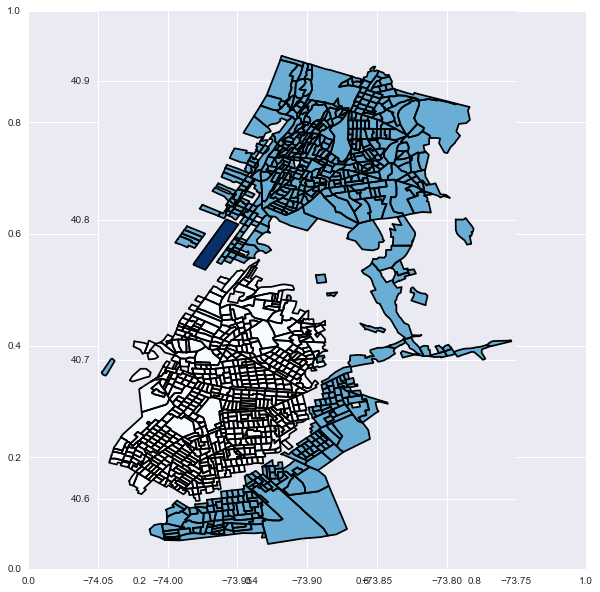

In [59]:
# And plotting it with a basemap
f, ax = plt.subplots(1, figsize=(10,10))
gdata.plot(column='quadrant', scheme='QUANTILES', k=4, alpha=1.0, colormap='Blues')
# mplleaflet.display(fig=f, crs=gdata.crs)

In [62]:
final_merge.shape

(1212, 188)